In [1]:
%load_ext lab_black

In [111]:
%%writefile data_wrangling.py
import numpy as np
import pandas as pd


def gen_pkey(p_file="../common/patterns/mappingv2.txt"):
    """
    Read phonological patterns from the mapping file
    See Harm & Seidenberg PDF file
    """

    mapping = pd.read_table(p_file, header=None, delim_whitespace=True)
    m_dict = mapping.set_index(0).T.to_dict('list')
    return m_dict


class wf_manager():
    # Note: the probability must sum to 1 when passing it to np.random.choice()
    def __init__(self, wf):

        self.wf = np.array(wf)

    def wf(self):
        return self.wf

    def to_p(self, x):
        return x / np.sum(x)

    def samp_termf(self):
        return self.to_p(self.wf)

    def samp_log(self):
        log = np.log(1 + self.wf)
        return self.to_p(log)

    def samp_hs04(self):
        root = np.sqrt(self.wf) / np.sqrt(30000)
        clip = root.clip(0.05, 1.0)
        return self.to_p(clip)

    def samp_jay(self):
        cap = self.wf.clip(0, 10000)
        root = np.sqrt(cap)
        return self.to_p(root)
    
    def samp_fromhallf_clip(self):
        ratio = self.wf / np.log(30000)  # Apply hs04-like sampling stregegy
        clip = ratio.clip(0.05, 1.0)                  
        return self.to_p(clip)

# Input for training set
def sample_generator(cfg, data):
    # Dimension guide: (batch_size, timesteps, nodes)
    from modeling import input_s

    np.random.seed(cfg.sample_rng_seed)
    epoch = 0
    batch = 0

    while True:
        batch += 1
        idx = np.random.choice(
            range(len(data.sample_p)), cfg.batch_size, p=data.sample_p
        )

        # Preallocate for easier indexing: (batch_size, time_step, input_dim)
        batch_s = np.zeros((cfg.batch_size, cfg.n_timesteps, cfg.pho_units))
        
        batch_y = []
        batch_y = data.y_train[idx]

#         for t in range(cfg.n_timesteps):
#             batch_y.append(data.y_train[idx])

        if batch % cfg.steps_per_epoch == 0:
            epoch += 1  # Counting epoch for ramping up input S

        if cfg.use_semantic == True:
            yield (
                [data.x_train[idx], batch_s, 2 * data.y_train[idx] - 1], batch_y
            )  # With negative input signal
        else:
            yield (data.x_train[idx], batch_y)


def test_set_input(
    x_test, x_test_wf, x_test_img, y_test, epoch, cfg, test_use_semantic
):
    # We need to separate whether the model use semantic by cfg.use_semantic
    # And whether the test set has semantic input by test_use_semantic
    # If model use semantic, we need to return a list of 3 inputs (x, s[time step varying], y), otherwise (x) is enough
    from modeling import input_s

    if cfg.use_semantic:
        batch_s = np.zeros(
            (len(x_test), cfg.n_timesteps, cfg.pho_units)
        )  # Fill batch_s with Plaut S formula
        batch_y = np.zeros_like(y_test)

        if test_use_semantic:
            for t in range(cfg.n_timesteps):
                s_cell = input_s(
                    e=epoch,
                    t=t * cfg.tau,
                    f=x_test_wf,
                    i=x_test_img,
                    gf=cfg.sem_param_gf,
                    gi=cfg.sem_param_gi,
                    kf=cfg.sem_param_kf,
                    ki=cfg.sem_param_ki,
                    hf=cfg.sem_param_hf,
                    hi=cfg.sem_param_hi,
                    tmax=cfg.max_unit_time - cfg.tau
                )  # Because of zero indexing
                batch_s[:, t, :] = np.tile(
                    np.expand_dims(s_cell, 1), [1, cfg.pho_units]
                )

            batch_y = 2 * y_test - 1  # With negative teaching signal

        return [x_test, batch_s, batch_y]  # With negative teaching signal

    else:
        return x_test


class my_data():
    def __init__(self, cfg):

        self.sample_name = cfg.sample_name
        self.csv_name = cfg.csv_name
        self.x_name = cfg.x_name
        self.y_name = cfg.y_name

        input_path = './input/'

        self.df_train = pd.read_csv(input_path + self.csv_name, index_col=0)
        self.x_train = np.load(input_path + self.x_name)['data']
        self.y_train = np.load(input_path + self.y_name)['data']

        from data_wrangling import gen_pkey
        self.phon_key = gen_pkey()

        print('==========Orthographic representation==========')
        print('x_train shape:', self.x_train.shape)
        print('y_train shape:', self.y_train.shape)
        
        # Select WF  
        self.sample_p = wf_manager(self.df_train.lwf).samp_fromhallf_clip()

Overwriting data_wrangling.py


# Tidy source files to keys csv

In [1]:
import pandas as pd
import numpy as np

# Read training file
train_file = '../common/patterns/6ktraining_v2.dict'

strain_file = '../common/patterns/strain.txt'
strain_key_file = '../common/patterns/strain_key.txt'

grain_file = '../common/patterns/grain_nws.dict'
grain_key_file = '../common/patterns/grain_key.txt'

# Imageability
cortese = pd.read_csv('../common/patterns/cortese2004norms.csv', skiprows=9)
img_map = cortese[['item', 'rating']]
img_map.columns = ['word', 'img']

train = pd.read_csv(
    train_file,
    sep='\t',
    header=None,
    names=['word', 'ort', 'pho', 'wf'],
    na_filter=
    False  # Bug fix: incorrectly treated null as missing value in the corpus
)

In [2]:
len(train)

5832

### Merge files from Noam, TASA, and BERT

In [3]:
naming = pd.read_csv('from_noam/naming.dol.jason.csv', na_filter=False)
naming = naming.rename(
    columns={
        "D_word": "word",
        "Log_Freq_HAL": "lwf",
        "mean.acc": "mean.acc.naming",
        "mean.RT": "mean.rt.naming"
    }
)
naming = naming[[
    'word', 'lwf', 'mean.cosine', 'mean.cosine.p2s', 'uncond.surprisal',
    'neigh.size.plus.1', 'p.neigh.size.plus.1', 'Length', 'mean.acc.naming',
    'mean.rt.naming'
]]

In [4]:
lexd = pd.read_csv('from_noam/lexDec.dol.jason.csv', na_filter=False)
lexd = lexd.rename(
    columns={
        "D_word": "word",
        "mean.acc.LD": "mean.acc.ld",
        "mean.RT.LD": "mean.rt.ld"
    }
)
lexd = lexd[['word', 'mean.acc.ld', 'mean.rt.ld']]

In [5]:
train['og_id'] = train.index
tr_na = train.merge(naming)
tr_na_ld = tr_na.merge(lexd)

In [6]:
# TASA Cleanup

tasa = pd.read_csv('embeddings/LSA_TASA/TASA.csv')
tasa['tasa_id'] = tasa.index
tasa = tasa.rename(columns={tasa.columns[0]: 'word'})

# Make wordlist for merging
tasa_wordlist = tasa.loc[:, ['word', 'tasa_id']]

# Actual embedding
tasa_embedding = tasa.drop(columns=['word', 'tasa_id'])
tasa_embedding = tasa_embedding.to_numpy()

# Save for easier loading
np.savez_compressed('embeddings/LSA_TASA/TASA.npz', data=tasa_embedding)

### TASA version (n=4396)

In [9]:
# Master data set
tr_na_ld_tasa = tr_na_ld.merge(tasa_wordlist)
tr_na_ld_tasa.to_csv('input/df_train_tasa.csv')

# x-train
x_train = np.load('../common/input/x_train.npz')['data']
x_train_tasa = x_train[tr_na_ld_tasa.og_id]
np.savez_compressed('input/x_train_tasa.npz', data=x_train_tasa)

# y-train
tasa = np.load('embeddings/LSA_TASA/TASA.npz')['data']
y_train_tasa = tasa[tr_na_ld_tasa.tasa_id]
np.savez_compressed('input/y_train_tasa.npz', data=y_train_tasa)

### BERT version (n=3262)

In [10]:
# Master data set
bert_words = pd.read_csv(
    'embeddings/bert/bert_wordlist.txt', header=None, names=['word']
)
bert_words['bert_id'] = bert_words.index
tr_na_ld_bert = tr_na_ld.merge(bert_words)
tr_na_ld_bert.to_csv('input/df_train_bert.csv')

# x-train
x_train = np.load('../common/input/x_train.npz')['data']
x_train_bert = x_train[tr_na_ld_bert.og_id]
np.savez_compressed('input/x_train_bert.npz', data=x_train_bert)

# y-train
bert = np.load('embeddings/bert/bert.npz')['data']
y_train_bert = bert[tr_na_ld_bert.bert_id]
np.savez_compressed('input/y_train_bert.npz', data=y_train_bert)

## Older compiling scripts

In [4]:
df_train = pd.merge(train, img_map, on='word', how='left')

strain = pd.read_csv(
    strain_file, sep='\t', header=None, names=['word', 'ort', 'pho', 'wf']
)

strain_key = pd.read_table(
    strain_key_file,
    header=None,
    delim_whitespace=True,
    names=['word', 'frequency', 'pho_consistency', 'imageability']
)

df_strain = pd.merge(strain, strain_key)
df_strain = pd.merge(df_strain, img_map, on='word', how='left')

grain = pd.read_csv(
    grain_file,
    sep='\t',
    header=None,
    names=['word', 'ort', 'pho_large', 'pho_small']
)

grain_key = pd.read_table(
    grain_key_file,
    header=None,
    delim_whitespace=True,
    names=['word', 'condition']
)

grain_key['condition'] = np.where(
    grain_key['condition'] == 'critical', 'ambiguous', 'unambiguous'
)

df_grain = pd.merge(grain, grain_key)

df_grain['img'] = 0
df_grain['wf'] = 0


def prepDF(t):
    # The first bit and last 3 bits are empty in this source dataset (6ktraining.dict)
    t['ort'] = t.ort.apply(lambda x: x[1:11])
    return t


df_train = prepDF(df_train)
df_strain = prepDF(df_strain)
df_grain = prepDF(df_grain)

# Fill missing value to mean img rating
mean_img = df_train.img.mean()
df_train = df_train.fillna(mean_img)
df_strain = df_strain.fillna(mean_img)

df_train.to_csv('../common/input/df_train.csv')
df_strain.to_csv('../common/input/df_strain.csv')
df_grain.to_csv('../common/input/df_grain.csv')

print(df_train.head)
print(df_strain.head)
print(df_grain.head)

<bound method NDFrame.head of         word         ort         pho         wf       img
0          a  ___a______  ___^______  1100290.0  4.194246
1        ace  ___a_ce___  ___es_____      117.0  4.500000
2       ache  ___a_che__  ___ek_____       27.0  3.800000
3      ached  ___a_ched_  ___ekt____        3.0  4.194246
4      aches  ___a_ches_  ___eks____       23.0  4.194246
...      ...         ...         ...        ...       ...
5827     zoo  __zoo_____  __zu______      172.0  6.800000
5828    zoom  __zoom____  __zum_____       38.0  3.500000
5829  zoomed  __zoomed__  __zumd____       44.0  4.194246
5830   zooms  __zooms___  __zumz____       18.0  4.194246
5831    zoos  __zoos____  __zuz_____       23.0  4.194246

[5832 rows x 5 columns]>
<bound method NDFrame.head of       word         ort         pho     wf frequency pho_consistency  \
0     ball  __ba_ll___  __bal_____   1393        HF             INC   
1     bank  __ba_nk___  __b@nk____  53170        HF             CON   
2    

# Encode input and output

In [5]:
# Encode orthographic representation
def ort2bin(o_col, trimMode=True, verbose=True):
    # Replicating support.py (o_char)
    # This function wrap tokenizer.texts_to_matrix to fit on multiple
    # independent slot-based input
    # i.e. one-hot encoding per each slot with independent dictionary

    from tensorflow.keras.preprocessing.text import Tokenizer

    nSlot = len(o_col[0])
    nWord = len(o_col)

    slotData = nWord * [None]
    binData = pd.DataFrame()

    for slotId in range(nSlot):
        for wordId in range(nWord):
            slotData[wordId] = o_col[wordId][slotId]

        t = Tokenizer(filters='', lower=False)
        t.fit_on_texts(slotData)
        seqData = t.texts_to_sequences(
            slotData
        )  # Maybe just use sequence data later

        # Triming first bit in each slot
        if trimMode == True:
            tmp = t.texts_to_matrix(slotData)
            thisSlotBinData = tmp[:, 1::
                                 ]  # Remove the first bit which indicate a separate slot (probably useful in recurrent network)
        elif trimMode == False:
            thisSlotBinData = t.texts_to_matrix(slotData)

        # Print dictionary details
        if verbose == True:
            print('In slot ', slotId, '\t')
            print('token count:', t.word_counts)
            print('word count:', t.document_count)
            print('dictionary:', t.word_index)
            print('token appear in how many words:', t.word_docs)

        # Put binary data into a dataframe
        binData = pd.concat(
            [binData, pd.DataFrame(thisSlotBinData)], axis=1, ignore_index=True
        )

    return binData


def ort2bin_v2(o_col):
    # Use tokenizer instead to acheive same thing, but with extra zeros columns
    # Will be useful for letter level recurrent model
    from tensorflow.keras.preprocessing.text import Tokenizer
    t = Tokenizer(filters='', lower=False, char_level=True)
    t.fit_on_texts(o_col)
    print('dictionary:', t.word_index)
    return t.texts_to_matrix(o_col)

In [7]:
# Merge all 3 ortho representation
all_ort = pd.concat(
    [df_train.ort, df_strain.ort, df_grain.ort], ignore_index=True
)

# Encoding orthographic representation
all_ort_bin = ort2bin(all_ort, verbose=False)
splitId_strain = len(df_train)
splitId_grain = len(df_train) + len(df_strain)

x_train = np.array(all_ort_bin[0:splitId_strain])
x_strain = np.array(all_ort_bin[splitId_strain:splitId_grain])
x_grain = np.array(all_ort_bin[splitId_grain::])

# Save to disk
np.savez_compressed('../common/input/x_train.npz', data=x_train)
np.savez_compressed('../common/input/x_strain.npz', data=x_strain)
np.savez_compressed('../common/input/x_grain.npz', data=x_grain)

print('==========Orthographic representation==========')
print('all shape:', all_ort_bin.shape)
print('x_train shape:', x_train.shape)
print('x_strain shape:', x_strain.shape)
print('x_grain shape:', x_grain.shape)


def pho2bin_v2(p_col, p_key):
    # Vectorize for performance (that no one ask for... )
    binLength = len(p_key['_'])
    n = len(p_col)
    nPhoChar = len(p_col[0])

    p_output = np.empty([n, binLength * nPhoChar])

    for slot in range(len(p_col[0])):
        slotSeries = p_col.str.slice(start=slot, stop=slot + 1)
        outSeries = slotSeries.map(p_key)
        p_output[:, range(slot * 25, (slot + 1) * 25)] = outSeries.to_list()
    return p_output


from data_wrangling import gen_pkey
phon_key = gen_pkey()
y_train = pho2bin_v2(train.pho, phon_key)
y_strain = pho2bin_v2(strain.pho, phon_key)
y_large_grain = pho2bin_v2(grain.pho_large, phon_key)
y_small_grain = pho2bin_v2(grain.pho_small, phon_key)

# Save to disk
np.savez_compressed('../common/input/y_train.npz', data=y_train)
np.savez_compressed('../common/input/y_strain.npz', data=y_strain)
np.savez_compressed('../common/input/y_large_grain.npz', data=y_large_grain)
np.savez_compressed('../common/input/y_small_grain.npz', data=y_small_grain)

print('\n==========Phonological representation==========')
print(len(phon_key), ' phonemes: ', phon_key.keys())
print('y_train shape:', y_train.shape)
print('y_strain shape:', y_strain.shape)
print('y_large_grain shape:', y_large_grain.shape)
print('y_small_grain shape:', y_small_grain.shape)

==========Orthographic representation==========
all shape: (6112, 119)
x_train shape: (5832, 119)
x_strain shape: (160, 119)
x_grain shape: (120, 119)

==========Phonological representation==========
38  phonemes:  dict_keys(['r', '@', 'Y', 'U', 'C', 'O', 'y', 'a', 'h', '_', 'v', 'p', 'o', 'S', 'l', 'g', 'e', 'z', 'I', '^', 's', 'b', 'T', 'J', 'u', 'd', 'm', 'W', 'E', 'w', 'n', 'A', 'D', 'f', 'Z', 'k', 't', 'i'])
y_train shape: (5832, 250)
y_strain shape: (160, 250)
y_large_grain shape: (120, 250)
y_small_grain shape: (120, 250)


# Testing and evaluating new sampling probability

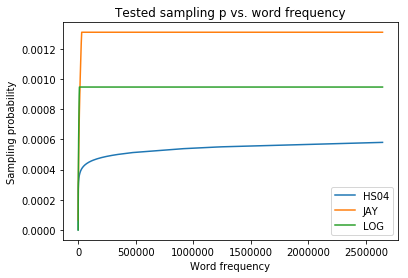

In [8]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('../common/input/df_train.csv', index_col=0)

# Plot sampling conversion graph
import matplotlib.pyplot as plt
from data_wrangling import wf_manager

plot_f = df_train.sort_values('wf')
sortwf = wf_manager(plot_f['wf'])

fig, ax = plt.subplots(facecolor="w")
line1, = ax.plot(sortwf.wf, sortwf.samp_log(), label='HS04')
line2, = ax.plot(sortwf.wf, sortwf.samp_hs04(), label='JAY')
line3, = ax.plot(sortwf.wf, sortwf.samp_jay(), label='LOG')
ax.legend(loc='lower right')
plt.xlabel('Word frequency')
plt.ylabel('Sampling probability')
# plt.xlim([0,100])
plt.title('Tested sampling p vs. word frequency')
plt.show()